In [1]:
# Se cargan las dependencias necesarias
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[[18439, -24426, -66], [17593, -18459, 1530], [16799, -2399, 12375], [18972, 17545, 19345], [19010, 27945, 11632], [14558, 21964, -7770], [13722, -11681, -15383], [17493, -21619, -4932], [18743, -24620, 296], [17467, -17527, 1202], [16909, -922, 13031], [19128, 18437, 20105], [18969, 27464, 10878], [13982, 21284, -9449], [10631, 3801, -18901], [14718, -12733, -13389], [18577, -24810, 33], [17059, -16669, 1765], [16983, 1746, 14525], [19801, 21197, 19686], [18110, 28366, 7602], [13270, 19140, -11506], [11259, 979, -17810], [15254, -15443, -12872], [17828, -22972, -3118], [18207, -24322, 3355], [17325, 4856, 15532], [19509, 23224, 18104], [18060, 27415, 5672], [12901, 17015, -13403], [10962, -796, -18910], [15950, -16980, -10624], [18115, -23304, -2394], [18382, -23085, 532], [16780, -12328, 4195], [19985, 24590, 19375], [16628, 26910, 2083], [11981, 13893, -15638], [11686, -3854, -17990], [16585, -18745, -8951], [18665, -24508, -918], [17661, -21873, -690], [16933, -9339, 7148], [18145,

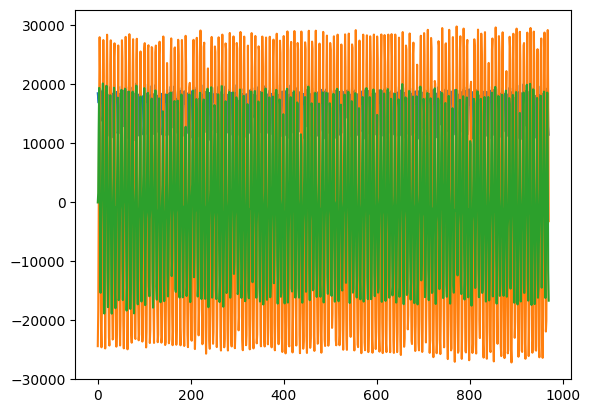

In [3]:
RutaFile="/content/drive/MyDrive/pruebas/Training/No lubrication.json.5cdkuekr.ingestion-7689984996-rpt7l.json"
dataframe = pd.read_json(RutaFile)
#print(dataframe.to_string())
Valores = dataframe.iloc[:,:].values
#print(Valores.shape)
#print(Valores)
print(Valores[7,2][0:-1])

DatosOri1=Valores[7,2][0:-1]
Datos1=np.array(DatosOri1)
print(Datos1.shape)
plt.plot(Datos1)

In [4]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Ruta a la carpeta donde están los archivos JSON
directory = '/content/drive/MyDrive/pruebas/Training/'

# Listar y ordenar los archivos
files = os.listdir(directory)
files.sort()
cantidadFiles = len(files)

# Número de clases y archivos por clase
num_classes = 4
files_per_class = cantidadFiles // num_classes  # Asumiendo 120 archivos distribuidos en 4 clases

# Parámetros del enventanado
sequence_length = 100  # Tamaño de la ventana
sequence_stride = 10   # Paso de la ventana deslizante

# Para almacenar las características y etiquetas
all_spectral_features = []
all_labels = []

# Función para extraer características espectrales
def extract_spectral_features(data, fs=49):
    features = []
    for axis_data in data.T:
        fft_result = np.fft.fft(axis_data)
        freqs = np.fft.fftfreq(len(axis_data), 1/fs)
        magnitude = np.abs(fft_result)
        positive_freqs = freqs[:len(freqs)//2]
        positive_magnitude = magnitude[:len(magnitude)//2]
        dominant_freq = positive_freqs[np.argmax(positive_magnitude)]
        total_energy = np.sum(positive_magnitude**2)
        low_band = np.sum(positive_magnitude[(positive_freqs < 10)]**2)
        mid_band = np.sum(positive_magnitude[(positive_freqs >= 10) & (positive_freqs < 20)]**2)
        high_band = np.sum(positive_magnitude[(positive_freqs >= 20)]**2)
        mean_amplitude = np.mean(positive_magnitude)
        std_amplitude = np.std(positive_magnitude)
        features.append([dominant_freq, total_energy, low_band, mid_band, high_band, mean_amplitude, std_amplitude])
    return np.concatenate(features)

# Procesar cada archivo individualmente
for idx, file in enumerate(files):
    # Ruta completa del archivo
    RutaFile = os.path.join(directory, file)

    # Leer el archivo JSON
    dataframe = pd.read_json(RutaFile)
    Valores = dataframe.iloc[:, :].values
    DatosOriDF = Valores[7, 2][0:-1]  # Extraer los datos de aceleración
    DatosOriNP = np.array(DatosOriDF)

    # Asegurarse de que los datos tengan la longitud correcta (970 muestras)
    Datos = DatosOriNP[0:970]
    Datos = Datos.reshape(-1, 3)  # Forma (970, 3), para X, Y, Z

    # Determinar la clase del archivo
    current_class = idx // files_per_class  # Clase correspondiente (0 a num_classes-1)

    # Crear ventanas deslizantes
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=Datos,
        targets=None,
        sequence_length=sequence_length,
        sequence_stride=sequence_stride,
        batch_size=32,
    )

    # Convertir a array numpy
    X_windows = np.concatenate([x.numpy() for x in dataset], axis=0)

    # Extraer características espectrales para cada ventana
    n_samples, _, n_axes = X_windows.shape
    spectral_features = np.zeros((n_samples, 7 * n_axes))
    for i in range(n_samples):
        spectral_features[i, :] = extract_spectral_features(X_windows[i])

    # Crear etiquetas para estas ventanas
    labels = np.full((n_samples,), current_class)

    # Agregar las características y etiquetas al conjunto total
    all_spectral_features.append(spectral_features)
    all_labels.append(labels)

# Concatenar todas las características y etiquetas
all_spectral_features = np.vstack(all_spectral_features)
all_labels = np.concatenate(all_labels)

# Estandarizar las características
scaler = StandardScaler()
all_spectral_features_scaled = scaler.fit_transform(all_spectral_features)

print("Forma final de las características escaladas:", all_spectral_features_scaled.shape)
print("Forma final de las etiquetas:", all_labels.shape)

# Convertir etiquetas a categóricas
all_labels_categorical = tf.keras.utils.to_categorical(all_labels, num_classes=num_classes)



Forma final de las características escaladas: (10560, 21)
Forma final de las etiquetas: (10560,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 21, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 21, 32)         │             64 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 21, 32)         │          8,416 │ dense[0][0],           │
│ (MultiHeadAttention)      │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 21, 32)         │             64 │ multi_head_attention[… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 32)             │              0 │ layer_normalization[0… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          1,056 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 4)              │            132 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,732 (38.02 KB)

 Trainable params: 9,732 (38.02 KB)

 Non-trainable params: 0 (0.00 B)

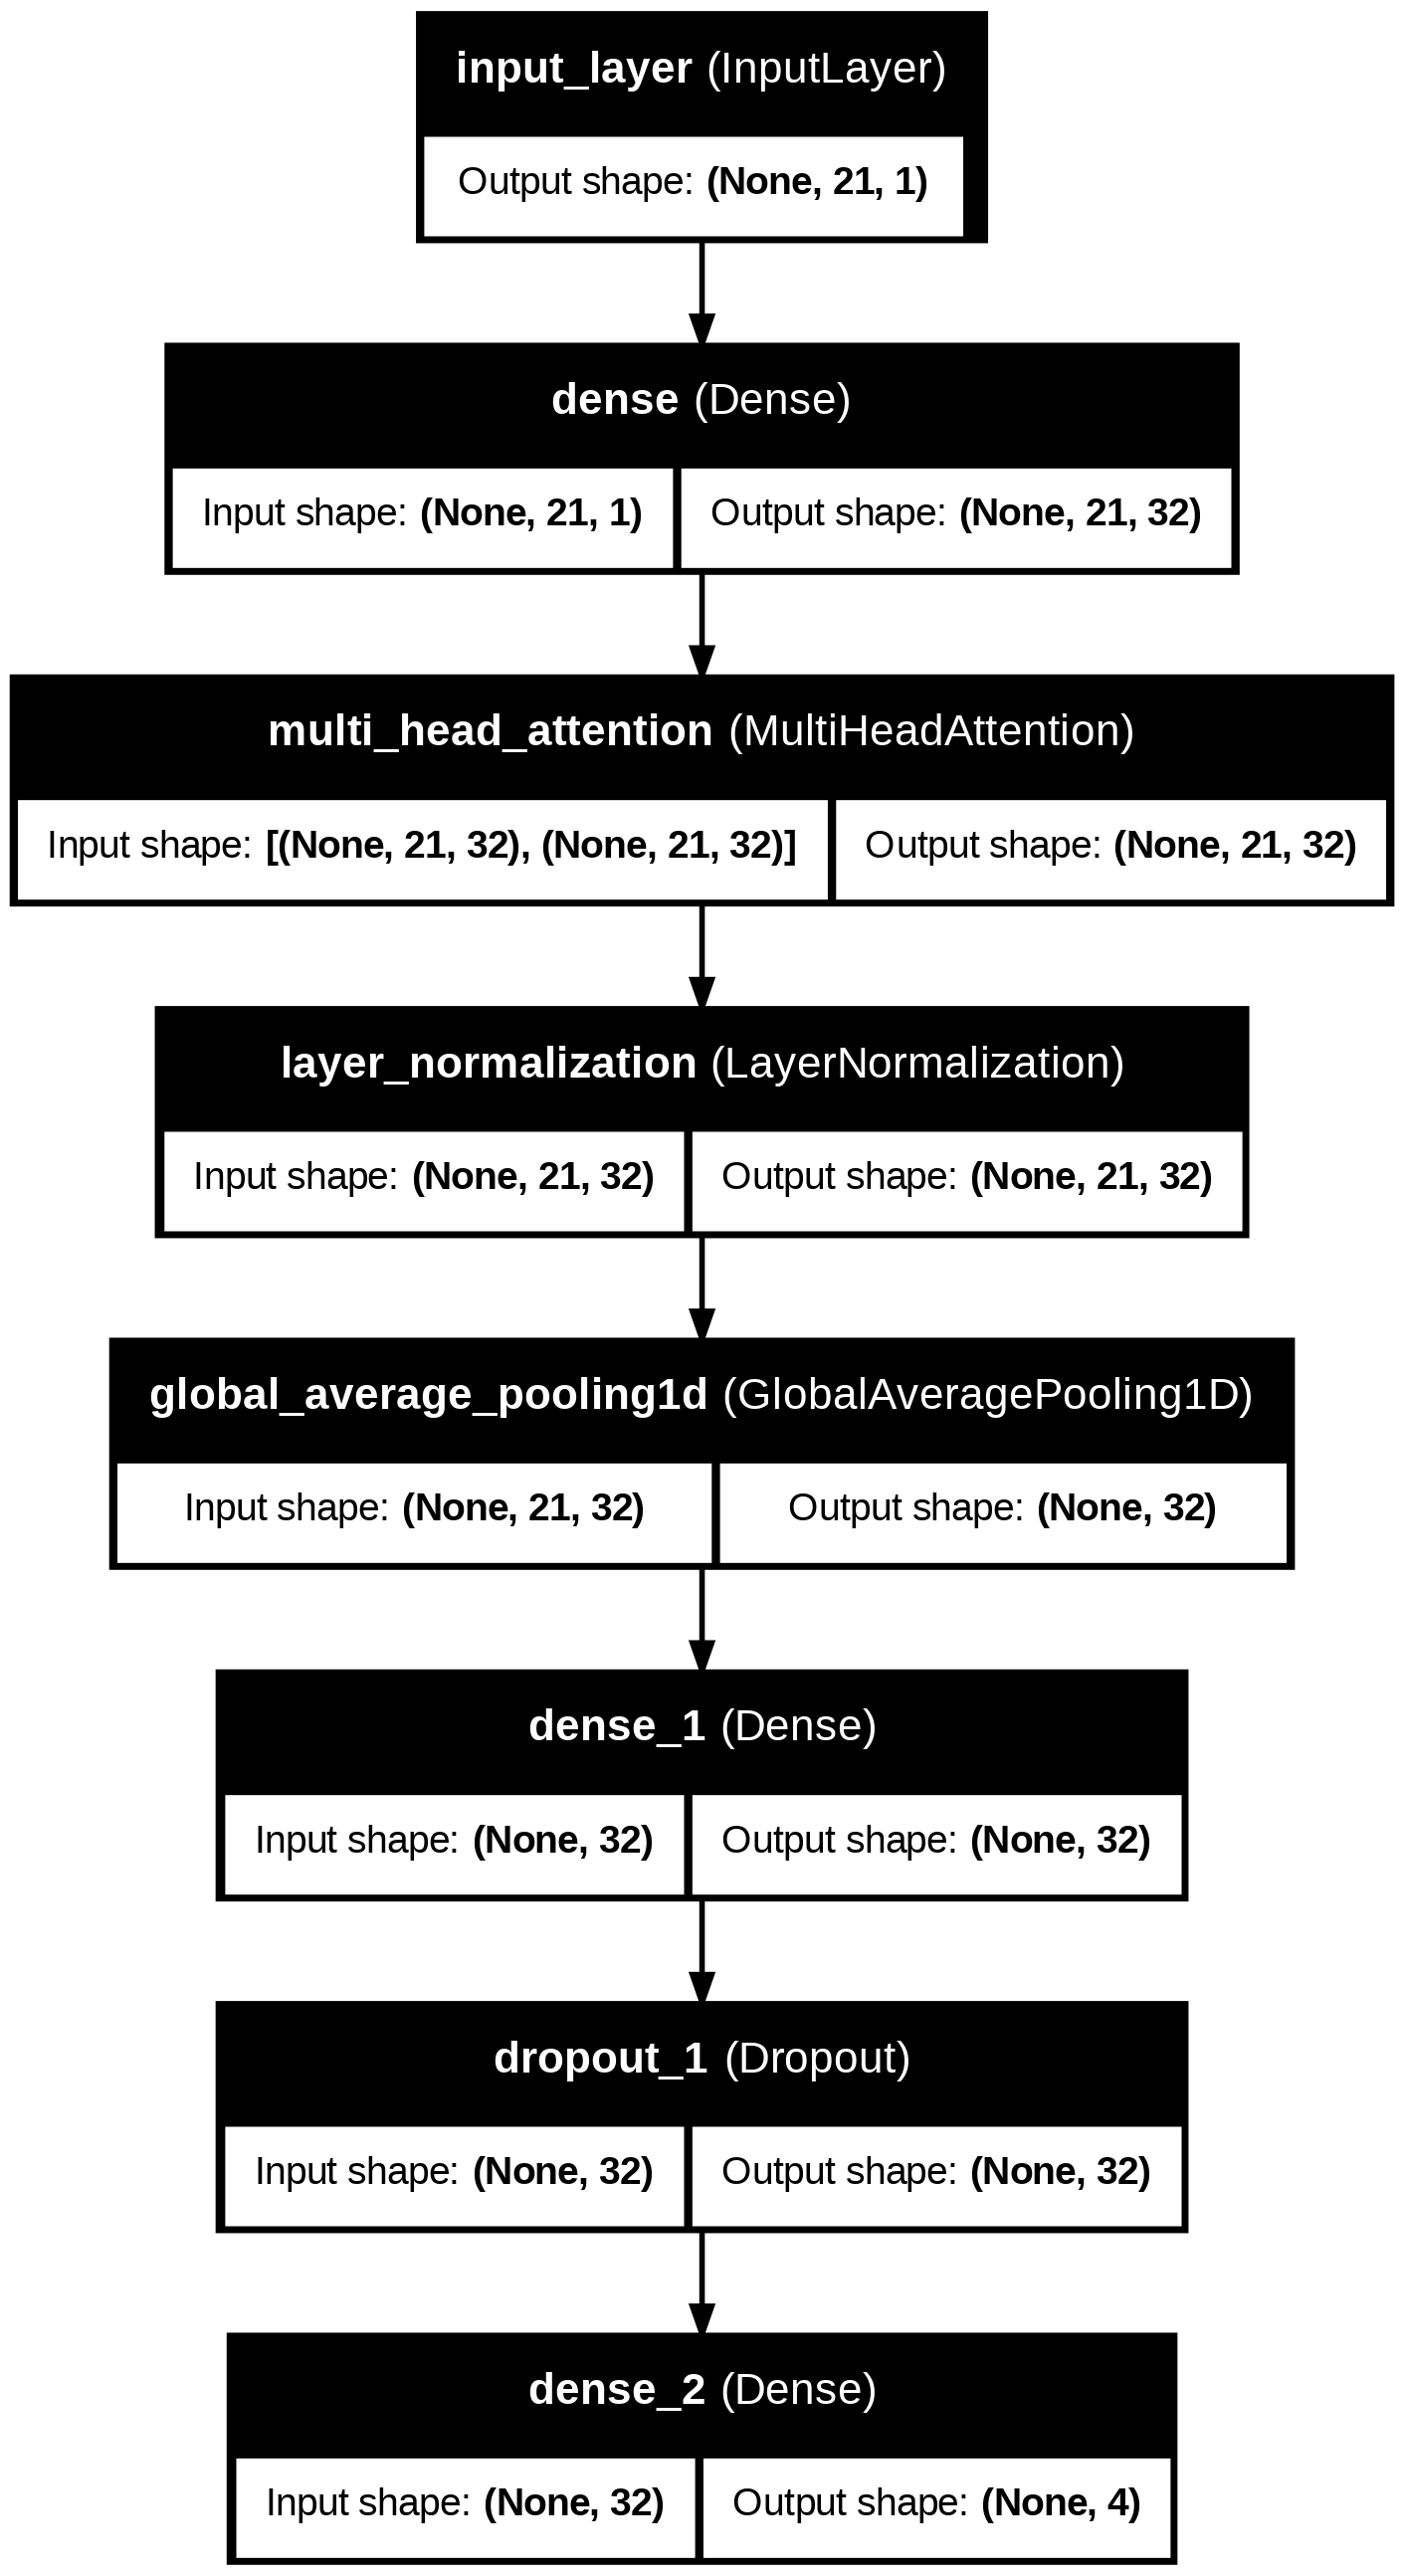

In [2]:
from keras.models import Model
from keras.layers import Dense, Input, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D

# Dimensiones del modelo
num_heads = 2  # Número de cabezas de atención
embedding_dim = 32  # Dimensión del embedding interno

# Entrada
inputs = Input(shape=(21, 1))  # Entrada con 21 características y 1 canal

# Capa de atención multi-cabeza
x = Dense(embedding_dim)(inputs)  # Proyectar a embedding_dim
x = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
x = LayerNormalization(epsilon=1e-6)(x)  # Normalización

# Agregar más capas densas y global pooling
x = GlobalAveragePooling1D()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)  # 4 clases

# Modelo
modelo_transformer = Model(inputs, outputs)
modelo_transformer.summary()

# Compilar el modelo
modelo_transformer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

keras.utils.plot_model(modelo_transformer, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)


In [6]:
from sklearn.model_selection import train_test_split

# Dividir datos en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(
    all_spectral_features_scaled, all_labels_categorical, test_size=0.20, random_state=42
)


In [7]:
X_train_reshaped = X_train.reshape(-1, 21, 1)  # Cambia -1 a tu tamaño de batch si es necesario

# Entrenamiento
historia = modelo_transformer.fit(X_train_reshaped, y_train, epochs=30, batch_size=32)

Epoch 1/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5433 - loss: 1.0604
Epoch 2/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7648 - loss: 0.6483
Epoch 3/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7887 - loss: 0.5900
Epoch 4/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7926 - loss: 0.5588
Epoch 5/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8033 - loss: 0.5426
Epoch 6/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8115 - loss: 0.5277
Epoch 7/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8160 - loss: 0.5170
Epoch 8/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8152 - loss: 0.5108
Epoch 9/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8225 - loss: 0.4981
Epoch 10/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8266 - loss: 0.4801
Epoch 11/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8222 - loss: 0.4860
Epoch 12/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/

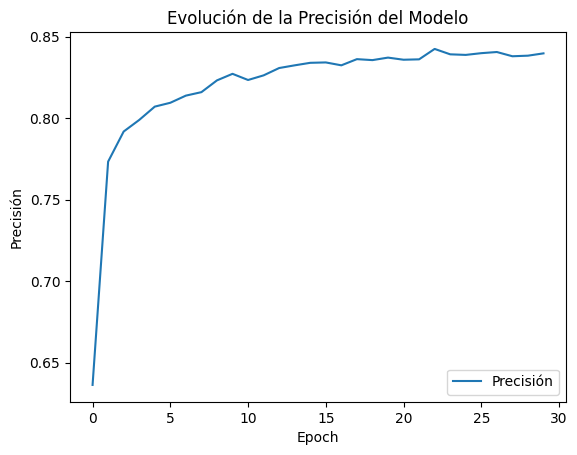

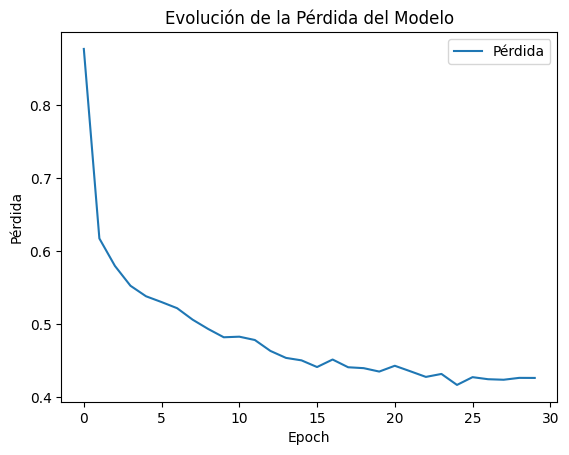

In [8]:
plt.plot(historia.history['accuracy'], label='Precisión')
plt.title('Evolución de la Precisión del Modelo')
plt.xlabel('Epoch')
plt.ylabel('Precisión')

plt.legend(loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(historia.history['loss'], label='Pérdida')
plt.title('Evolución de la Pérdida del Modelo')
plt.xlabel('Epoch')
plt.ylabel('Pérdida')
plt.legend(loc='upper right')
plt.show()

In [10]:
modelo_transformer.evaluate(X_val, y_val)

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8661 - loss: 0.3424


[0.35326457023620605, 0.8669507503509521]

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       528
           1       0.91      0.61      0.73       530
           2       0.82      0.94      0.87       524
           3       0.92      0.95      0.93       530

    accuracy                           0.87      2112
   macro avg       0.87      0.87      0.86      2112
weighted avg       0.87      0.87      0.86      2112

[[513   3  12   0]
 [ 71 325  94  40]
 [ 24   5 490   5]
 [  0  24   3 503]]


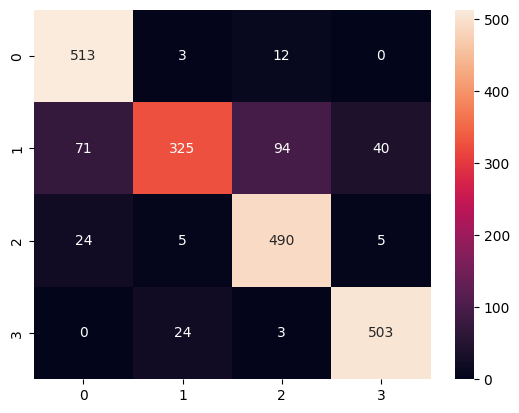

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

ypredic=modelo_transformer.predict(X_val)

y_test_class = np.argmax(y_val,axis=1)
y_pred_class = np.argmax(ypredic,axis=1)

#Accuracy of the predicted values
print(classification_report(y_test_class, y_pred_class)) # Precision , Recall, F1-Score & Support
cm = confusion_matrix(y_test_class, y_pred_class)
print(cm)
# visualize the confusion matrix in a heat map
df_cm = pd.DataFrame(cm)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Ruta del nuevo archivo JSON
nuevo_archivo = '/content/drive/MyDrive/pruebas/Training/No lubrication.json.5cdlmeh3.ingestion-7689984996-86jlz.json'

# Leer el archivo JSON
dataframe = pd.read_json(nuevo_archivo)
Valores = dataframe.iloc[:, :].values
DatosOriDF = Valores[7, 2][0:-1]  # Extraer los datos de aceleración
DatosOriNP = np.array(DatosOriDF)

# Asegurarse de que los datos tengan la longitud correcta (970 muestras como en los datos originales)
Datos = DatosOriNP[0:970]
Datos = Datos.reshape(-1, 3)  # Forma (970, 3), para X, Y, Z

# Parámetros del enventanado (mismos que en el entrenamiento)
sequence_length = 100
sequence_stride = 10

# Crear ventanas deslizantes
dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=Datos,
    targets=None,
    sequence_length=sequence_length,
    sequence_stride=sequence_stride,
    batch_size=32,
)

# Convertir las ventanas a un array numpy
X_windows = np.concatenate([x.numpy() for x in dataset], axis=0)

# Extraer características espectrales para las ventanas
def extract_spectral_features(data, fs=49):
    features = []
    for axis_data in data.T:
        fft_result = np.fft.fft(axis_data)
        freqs = np.fft.fftfreq(len(axis_data), 1/fs)
        magnitude = np.abs(fft_result)
        positive_freqs = freqs[:len(freqs)//2]
        positive_magnitude = magnitude[:len(magnitude)//2]
        dominant_freq = positive_freqs[np.argmax(positive_magnitude)]
        total_energy = np.sum(positive_magnitude**2)
        low_band = np.sum(positive_magnitude[(positive_freqs < 10)]**2)
        mid_band = np.sum(positive_magnitude[(positive_freqs >= 10) & (positive_freqs < 20)]**2)
        high_band = np.sum(positive_magnitude[(positive_freqs >= 20)]**2)
        mean_amplitude = np.mean(positive_magnitude)
        std_amplitude = np.std(positive_magnitude)
        features.append([dominant_freq, total_energy, low_band, mid_band, high_band, mean_amplitude, std_amplitude])
    return np.concatenate(features)

# Extraer características espectrales para todas las ventanas
n_samples, _, n_axes = X_windows.shape
spectral_features = np.zeros((n_samples, 7 * n_axes))
for i in range(n_samples):
    spectral_features[i, :] = extract_spectral_features(X_windows[i])

# Estandarizar las características espectrales (usar el scaler del entrenamiento)
spectral_features_scaled = scaler.transform(spectral_features)  # Usa el `scaler` ya entrenado

# Hacer predicciones con el modelo
predicciones = modelo_transformer.predict(spectral_features_scaled)

# Obtener la clase más probable para cada ventana
clases_predichas = np.argmax(predicciones, axis=1)

#print(f"Contenido de clases_predichas: {clases_predichas}")
#print(f"Forma de clases_predichas: {clases_predichas.shape}")

from collections import Counter

# Calcular la clase más frecuente manualmente
conteo_clases = Counter(clases_predichas)  # Contar ocurrencias de cada clase
prediccion_final = max(conteo_clases, key=conteo_clases.get)  # Clase con más ocurrencias

print(f"Predicción final para el archivo: Clase {prediccion_final}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
Predicción final para el archivo: Clase 0
